# PyTorchでのニューラルネットワークモデルの構築

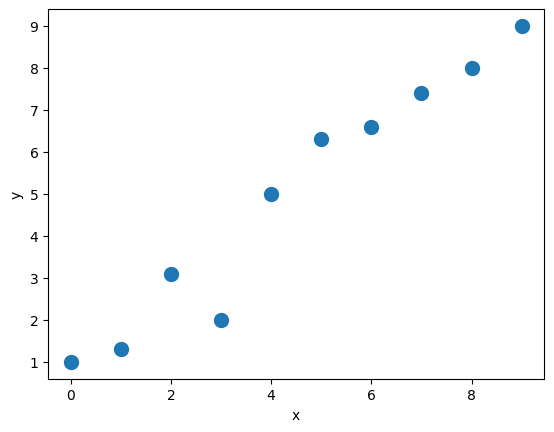

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

X_train = np.arange(10, dtype='float32').reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0], dtype='float32')


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [2]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train).float()
train_ds = TensorDataset(X_train_norm, y_train)
batch_size = 1
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [3]:
torch.manual_seed(1)
weight = torch.randn(1)
weight.requires_grad_() #自動微分（勾配計算）を有効にする。学習時にこの重みを更新できる。
bias = torch.zeros(1, requires_grad=True)
def model(xb):
    return xb * weight + bias

In [4]:
def loss_fn(input, target):
    return (input - target).pow(2).mean()

In [5]:
learning_rate = 0.001
num_epochs = 200
log_epochs = 20
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()  # 勾配計算
        with torch.no_grad():  # 勾配計算を無効にする
            weight -= learning_rate * weight.grad
            bias -= learning_rate * bias.grad
            weight.grad.zero_()  # 勾配をゼロにリセット
            bias.grad.zero_()  # 勾配をゼロにリセット
        
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 45.0782
Epoch 20, Loss: 1.5918
Epoch 40, Loss: 11.6038
Epoch 60, Loss: 0.6349
Epoch 80, Loss: 1.9999
Epoch 100, Loss: 0.7653
Epoch 120, Loss: 0.0235
Epoch 140, Loss: 0.0759
Epoch 160, Loss: 0.0008
Epoch 180, Loss: 0.0646


Final Parameters: 2.6696107387542725 4.879678249359131


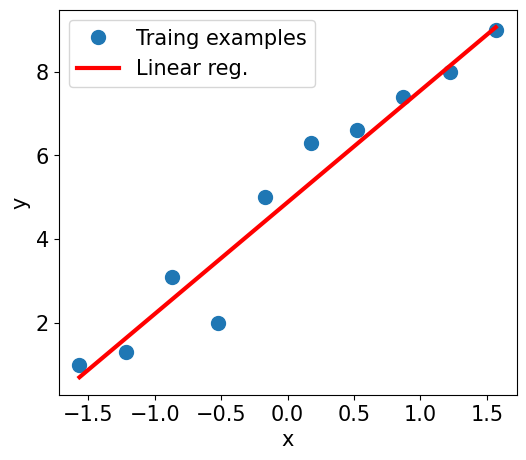

In [6]:
print(f'Final Parameters:', weight.item(), bias.item())
X_test = np.linspace(0, 9, num=100, dtype=np.float32).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()
fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, 'r-', linewidth=3)
plt.legend(['Traing examples', 'Linear reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

### torch.nnとtorch.optimを使ってモデルを訓練

In [7]:
import torch.nn as nn
loss_fn = nn.MSELoss(reduction='mean')
input_size = 1
output_size = 1
model = nn.Linear(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # 1. 予測値を生成
        pred = model(x_batch)[:, 0]
        # 2. 損失を計算
        loss = loss_fn(pred, y_batch)
        # 3. 勾配を計算
        loss.backward()
        # 4. 勾配を使ってパラメータを更新
        optimizer.step()
        # 5. 勾配をゼロにリセット
        optimizer.zero_grad()
        
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 24.6684
Epoch 20, Loss: 20.9207
Epoch 40, Loss: 12.4922
Epoch 60, Loss: 7.6425
Epoch 80, Loss: 0.0157
Epoch 100, Loss: 0.8412
Epoch 120, Loss: 0.0823
Epoch 140, Loss: 0.0891
Epoch 160, Loss: 0.1043
Epoch 180, Loss: 0.0009


In [8]:
# 定義したTensorに対して、「出力テンソルが入力テンソルに与える勾配」を、計算グラフを使って逆伝播で求める。
import torch
x = torch.tensor([3.0], requires_grad=True)
y = x ** 2
y.backward()  # OK
print(x.grad)  # tensor([6.])

tensor([6.])


In [9]:
print(f'Final Parameters:', model.weight.item(), model.bias.item())

Final Parameters: 2.6496422290802 4.87706995010376


### Irisデータセット

In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
X = iris['data']
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=1)

In [11]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train).float()
train_ds = TensorDataset(X_train_norm, y_train)
torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [12]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x
    
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
model = Model(input_size, hidden_size, output_size)

In [13]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

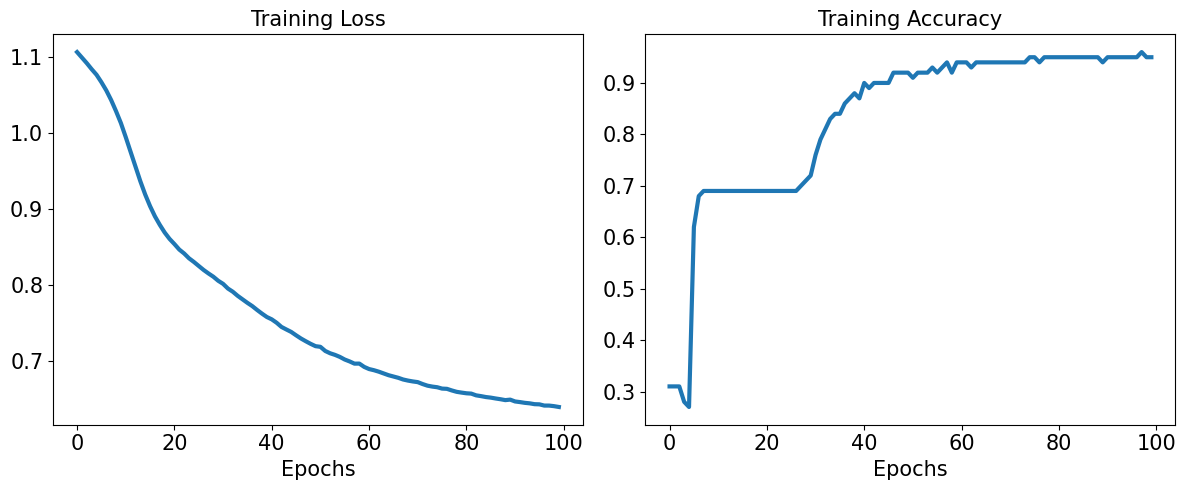

In [15]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(loss_hist, lw=3)
ax.set_title('Training Loss', size=15)
ax.set_xlabel('Epochs', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(accuracy_hist, lw=3)
ax.set_title('Training Accuracy', size=15)
ax.set_xlabel('Epochs', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

In [16]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test).float()
pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Accuracy: {accuracy.item():.4f}')

Test Accuracy: 0.9800


### 訓練したモデルの保存と読み込み

In [17]:
path = 'iris_classifier.pt'
torch.save(model, path)

In [19]:
model_new = torch.load(path, weights_only=False)

In [ ]:
model_new.eval()  # 評価モードに切り替え

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [21]:
pred_test = model_new(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc: {accuracy:.4f}')

Test Acc: 0.9800


In [22]:
# 学習したパラメータだけを保存する
path = 'iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [23]:
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>